# Forward modeling tutorial using mosaic images
## Generate spectra

In [1]:
from grizli import model
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy import wcs
from astropy.io import fits
from glob import glob
import seaborn as sea
import os

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Read in spectra

In [9]:
wv,fl,er = np.load('galaxy_spec.npy')

## Read in BeamCutout

In [2]:
co  = model.BeamCutout(fits_file='beams/o22.0_21156.g102.A.fits')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


## Generate flat

In [3]:
flat = co.flat_flam.reshape(co.beam.sh_beam)
fwv, ffl, e = co.beam.optimal_extract(flat, bin=0)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


## Read in model

In [27]:
mwv, mfl = np.load('model_spec/m0.019_a3.0_dt8.0_spec.npy')

## Redshift and Forward model

In [28]:
co.beam.compute_model(spectrum_1d=[mwv * (1 + 1.248), mfl])

True

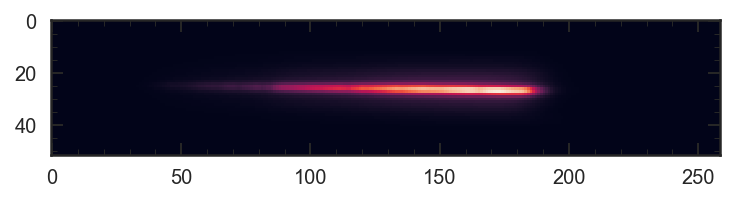

In [29]:
plt.imshow(co.beam.model)

## Extract the model (error array here is meaningless)

In [30]:
w, f, e = co.beam.optimal_extract(co.beam.model, bin=0)

In [31]:
## interpolate spectra to match galaxy spectra
ifl = interp1d(w,f/ffl)(wv)

In [32]:
## function to scale model
def Scale_model(D, sig, M):
    C = np.sum(((D * M) / sig ** 2)) / np.sum((M ** 2 / sig ** 2))
    return C

In [33]:
##Scale model
C = Scale_model(fl, er,ifl)

(0, 7.5e-18)

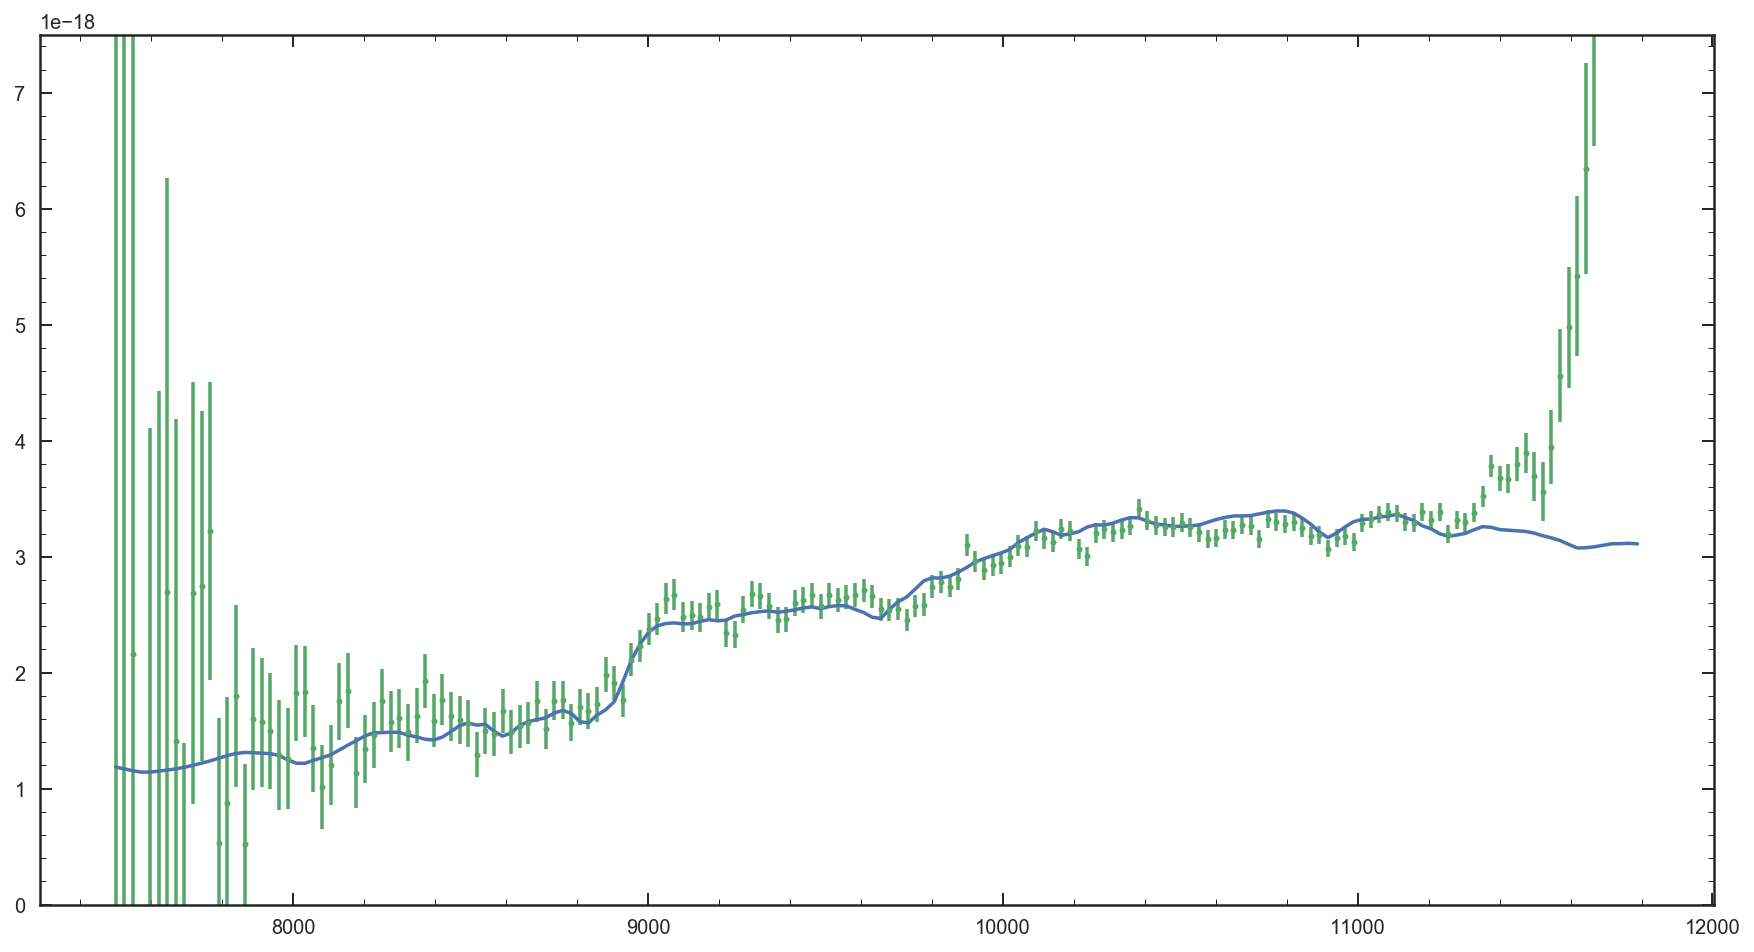

In [34]:
plt.figure(figsize=[15,8])

plt.plot(wv,C*ifl)
plt.errorbar(wv,fl,er,linestyle='None', marker='o', markersize=3)
plt.ylim(0,0.75E-17)

In [38]:
class Gen_spec(object):
    def __init__(self, beam, redshift,gal_wv, gal_fl, gal_er, minwv = 7800, maxwv = 11200):
        self.beam = model.BeamCutout(fits_file = beam)
        self.redshift = redshift
        self.gal_wv = gal_wv 
        self.gal_fl = gal_fl
        self.gal_er = gal_er
        """ 


        """

        IDX = [U for U in range(len(self.gal_wv)) if minwv <= self.gal_wv[U] <= maxwv]

        self.gal_wv_rf = gal_wv[IDX] / (1 + self.redshift)
        self.gal_wv = gal_wv[IDX]
        self.gal_fl = gal_fl[IDX]
        self.gal_er = gal_er[IDX]

        ## Get sensitivity function
        flat = self.beam.flat_flam.reshape(self.beam.beam.sh_beam)
        fwv, ffl, e = self.beam.beam.optimal_extract(flat, bin=0)
        
        self.filt = interp1d(fwv, ffl)(self.gal_wv)
        
    def Sim_spec(self, model_wv, model_fl, model_redshift = 0, dust = 0):
        if model_redshift ==0:
            model_redshift = self.redshift 
        
        ## Compute the models
        self.beam.compute_model(spectrum_1d=[model_wv*(1+model_redshift),model_fl])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(self.beam.model , bin=0)

        ifl = interp1d(w, f)(self.gal_wv)
        
        C = Scale_model(self.gal_fl, self.gal_er, ifl / self.filt)

        self.fl = C * ifl / self.filt

In [39]:
beams = glob('beams/*')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt

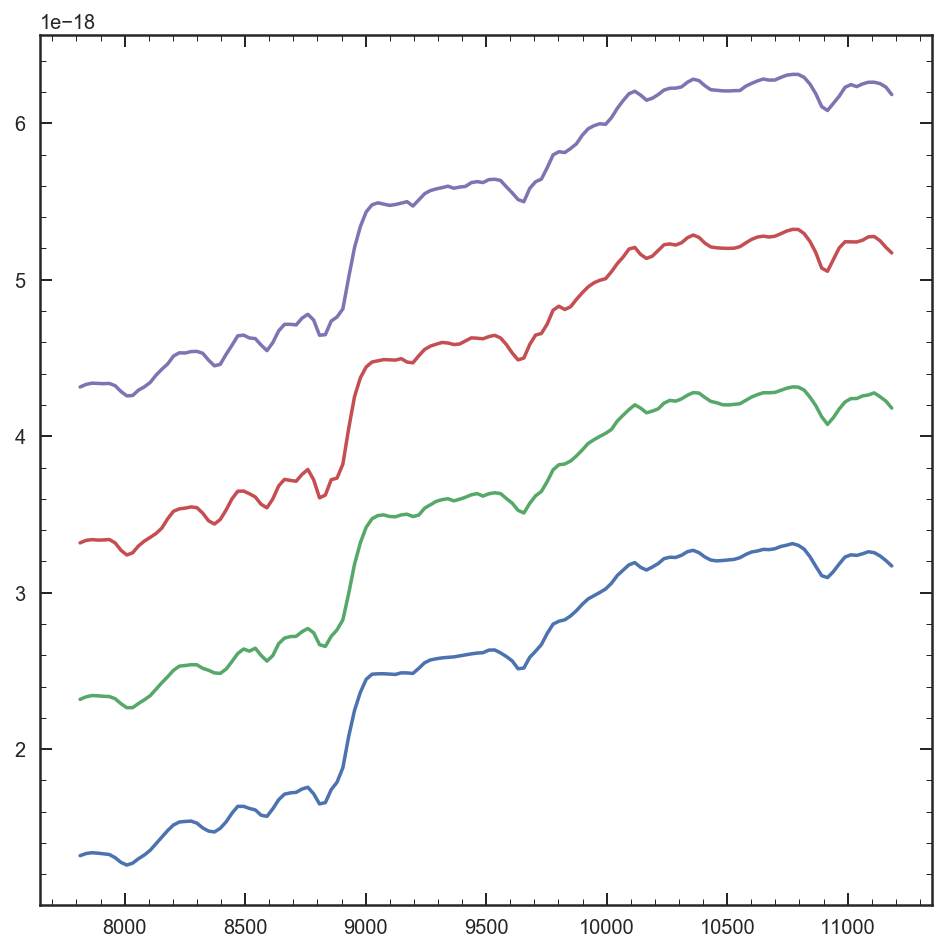

In [44]:
mwv, mfl = np.load('model_spec/m0.019_a2.5_dt8.0_spec.npy')

plt.figure(figsize=[8,8])

for i in range(len(beams)):
    sp = Gen_spec(beams[i], 1.248, wv, fl, er)
    sp.Sim_spec(mwv, mfl)
    
    plt.plot(sp.gal_wv, sp.fl+(i*0.1E-17))